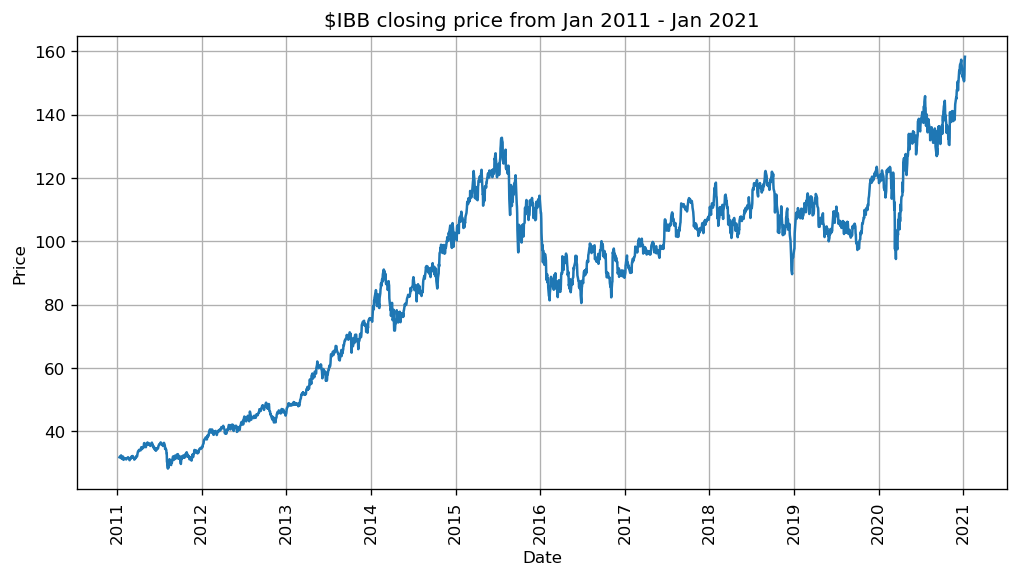

In [5]:
import numpy as np 
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

def parser(x):
    return datetime.strptime(x, "%Y-%m-%d")


data = pd.read_csv('IBB.csv', usecols=[0,4], parse_dates=[0], header=0, date_parser=parser)

plt.figure(figsize=[10, 5]); # Set dimensions for figure
plt.plot(data['Date'], data['Close'])
plt.title('$IBB closing price from Jan 2011 - Jan 2021')
plt.ylabel('Price')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

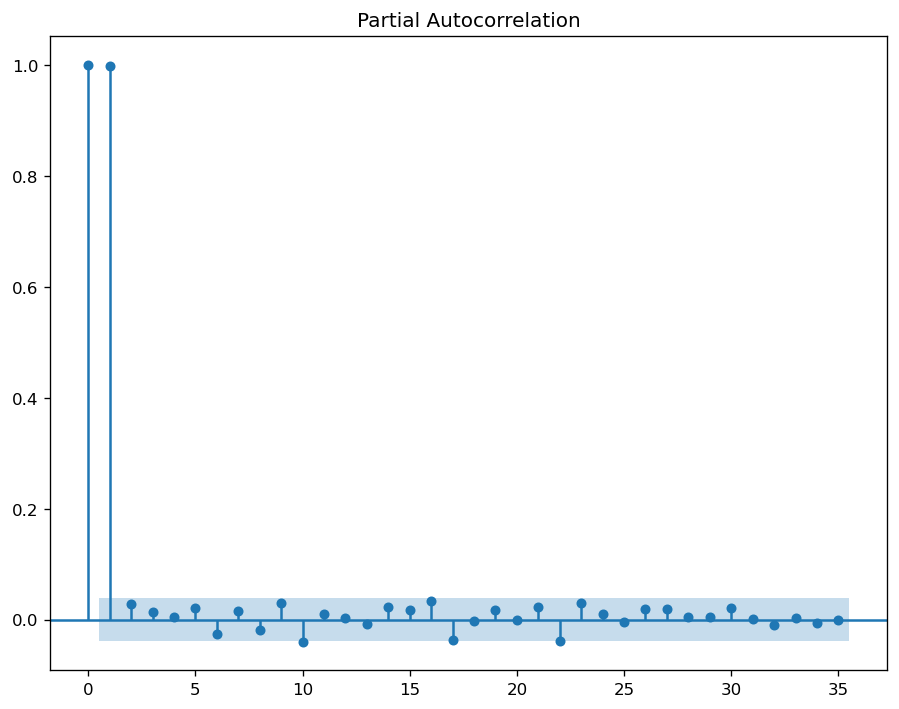

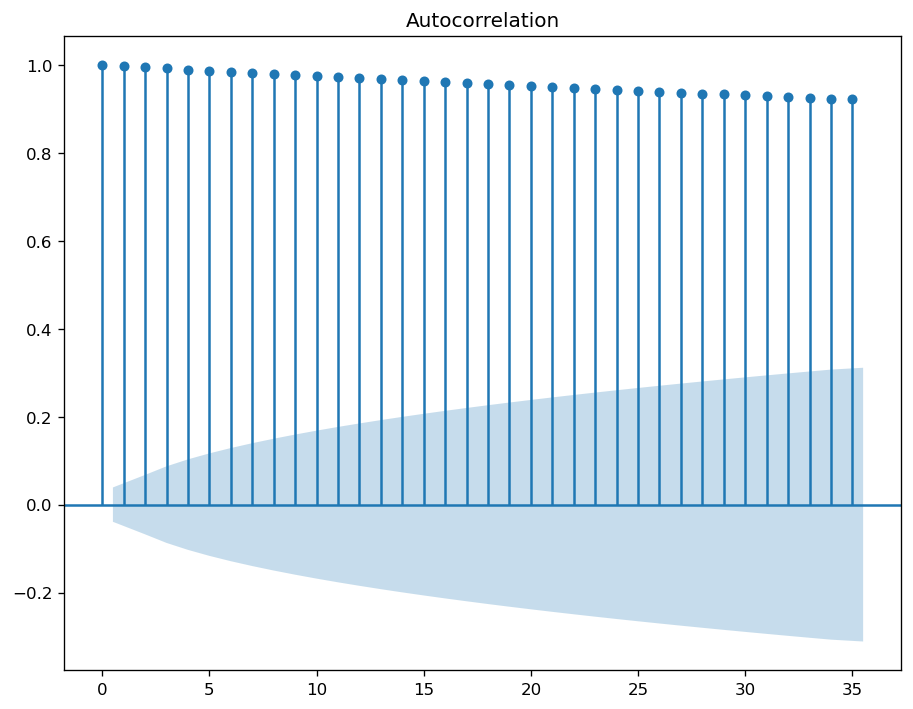

In [7]:
plot_pacf(data['Close'])
plot_acf(data['Close'])
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller
# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(data['Close'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.6200961337045798
p-value: 0.8663761624686823


In [10]:
# Take the log difference to make data stationary

data['Close'] = np.log(data['Close'])
data['Close'] = data['Close'].diff()
data = data.drop(data.index[0])
data.head()

,Date,Close
1,2011-01-12,0.005433
2,2011-01-13,0.000937
3,2011-01-14,0.001456
4,2011-01-18,0.010957
5,2011-01-19,-0.024561


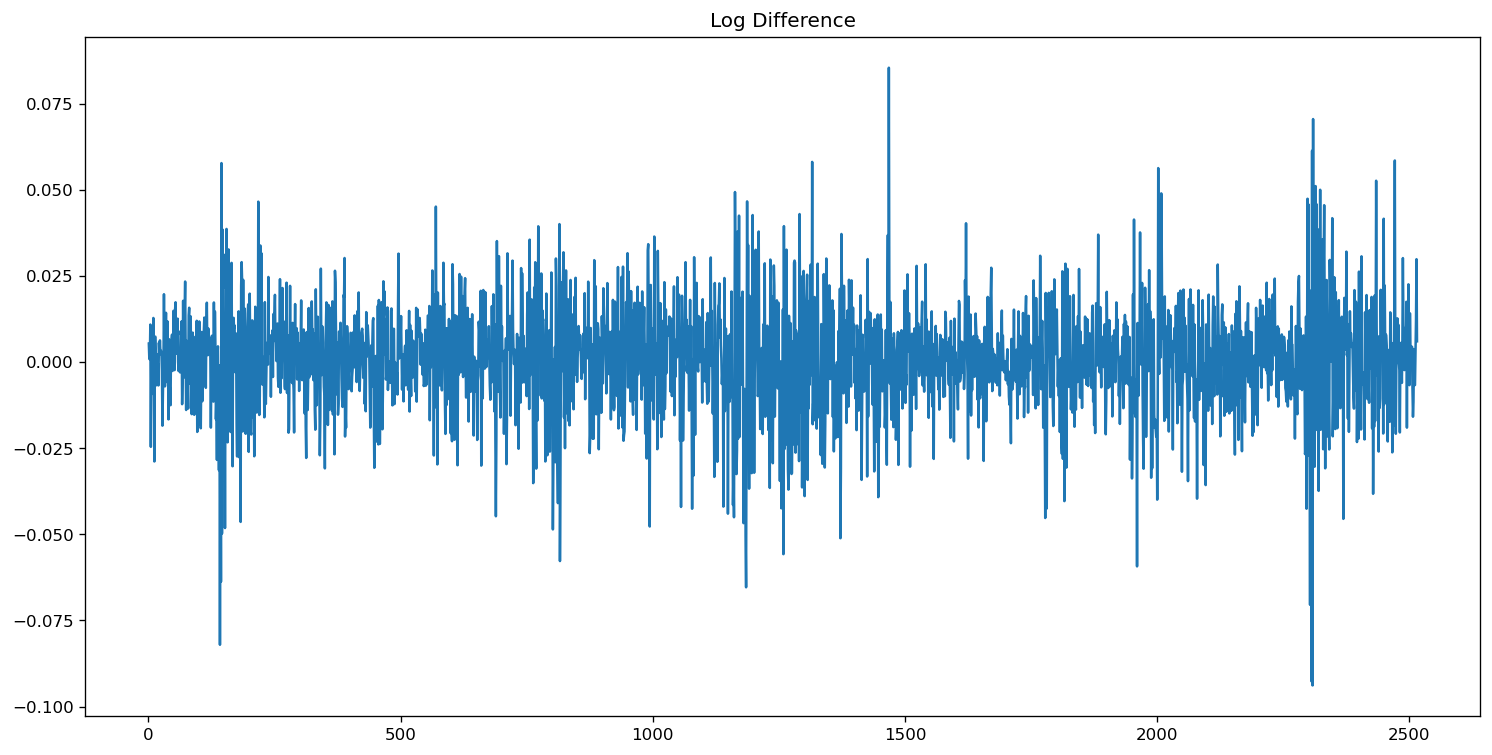

In [11]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['Close'])
plt.title("Log Difference")
plt.show()

In [12]:
# Augmented Dickey-Fuller test for log

ad_fuller_result = adfuller(data['Close'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -18.589536471610753
p-value: 2.074127275853548e-30


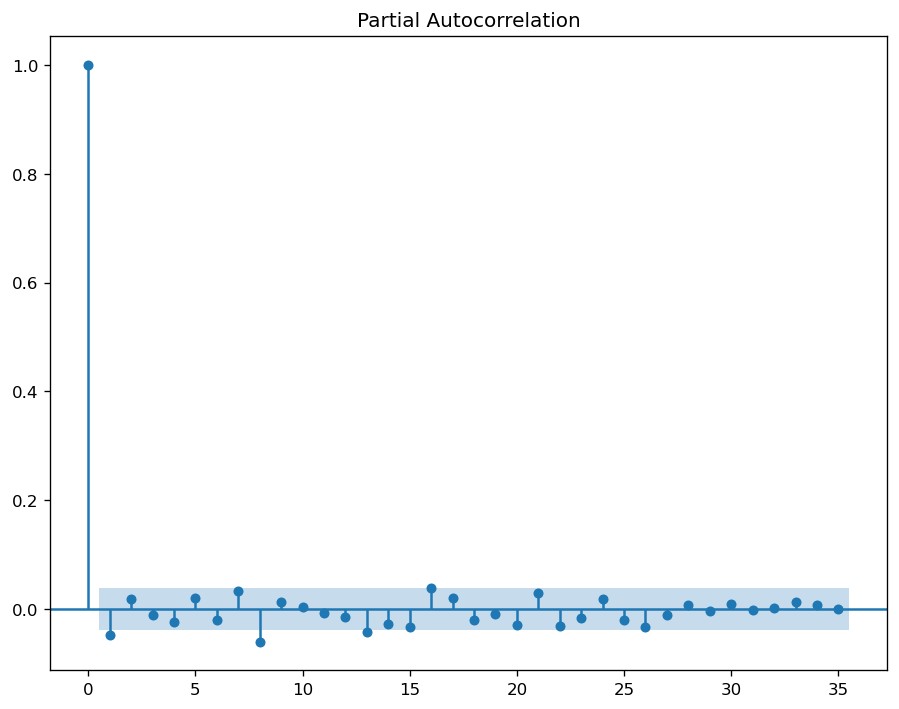

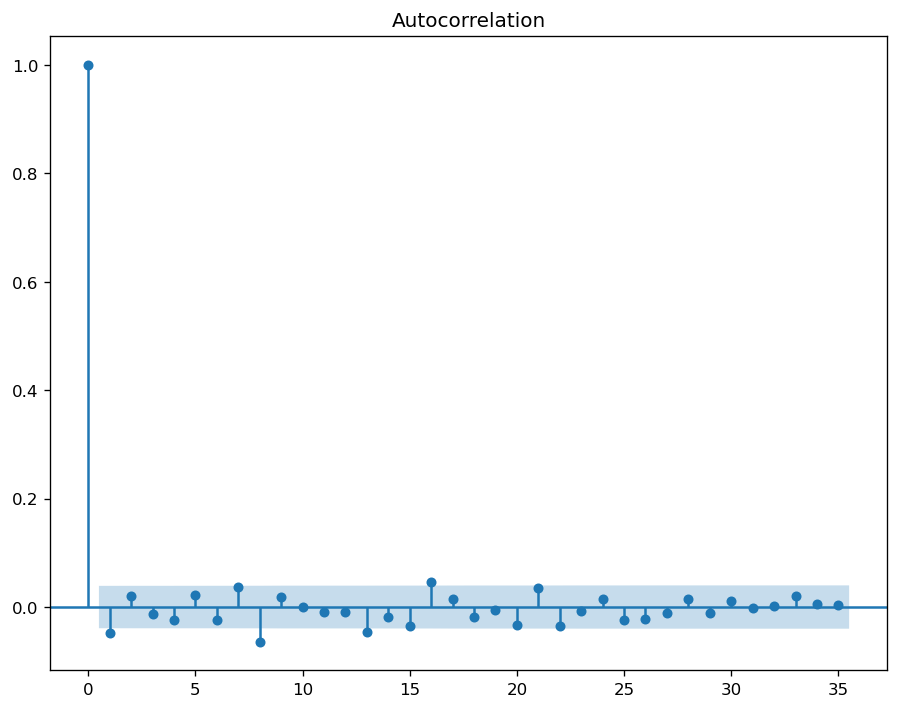

In [13]:
plot_pacf(data['Close'])
plot_acf(data['Close'])
plt.show()